<a href="https://colab.research.google.com/github/Poirazi-Lab/dendrify/blob/main/paper_figures/Fig2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
> *In this interactive Python notebook, we present and briefly discuss the code needed to replicate the model and the results shown in Figure 2 of the manuscript. With this basic example our goal is to illustrate:*
>
> - *Dendrify's simplistic, Lego-style code approach used to facilitate any reduced model's description.*
>
> - *That even rudimentary compartmental models perform functions that cannot be captured by point-neuron models often used in SNNs.*
>
>
> <hr>
>
> *__Note__: In case you are unfamiliar with how Python notebooks work and you would like to run or rerun the entire code, simply select one of the options bellow:*
>
> - **Runtime ➝ Run all**
> - **Runtime ➝ Restart and run all**
>
> *located on the top menu and wait a few seconds until all cells finish running.*
> <hr>
>
> *All source code of the current Dendrify version is available on* [GitHub](https://github.com/Poirazi-Lab/dendrify)

## Setup

In [1]:
#@title Install dependencies (might take a few seconds)
# !pip install brian2 --quiet
# !pip install dendrify --quiet

In [2]:
#@title Imports and settings
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt) # Generally a better practise than*imports
from dendrify import Soma, Dendrite, NeuronModel

b.prefs.codegen.target = 'numpy' # Improves performance significantly here
b.start_scope()  # allows running separate simulations in the same notebook
b.seed(1234)  # For reproducibility

# @title Figure settings
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, orange, green])
          }

b.rcParams.update(params)

## Build model
> Let's first create a 3-compartment toy model with passive dendrites:

In [3]:
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um)
apical = Dendrite('apical', length=250*um, diameter=2*um)
basal = Dendrite('basal', length=150*um, diameter=2*um)
# Add noise
apical.noise(tau=20*ms, sigma=3*pA, mean=0*pA)
basal.noise(tau=20*ms, sigma=3*pA, mean=0*pA)
# Add synapses
apical.synapse('AMPA', pre='cortex', g=1*nS, t_decay=2*ms)
apical.synapse('NMDA', pre='cortex', g=1*nS, t_decay=60*ms)
# Merge compartments into a  neuron model and set its properties
edges = [(soma, apical, 10*nS), (soma, basal, 10*nS)]
pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=50*uS/(cm**2),
                          v_rest=-70*mV, r_axial=150*ohm*cm,
                          scale_factor=3, spine_factor=1.5)
# Create a Brian NeuronGroup and link it to the neuron model
pyr_group = b.NeuronGroup(3, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = -50*mV',
                          refractory=3*ms, namespace=pyr_model.parameters)
pyr_model.link(pyr_group)

> *We can inspect what Dendrify did for us by simply printing the NeuronModel object we created. As we see, even simplistic toy models require a fair amount of differential equations and parameters.*

In [4]:
print(pyr_model)

OBJECT TYPE:

  <class 'dendrify.neuronmodel.NeuronModel'>

---------------------------------------------

PROPERTIES (type): 

→ equations (str):
    dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
    I_soma = I_ext_soma + I_basal_soma  + I_apical_soma   :amp
    I_ext_soma  :amp
    I_apical_soma = (V_apical-V_soma) * g_apical_soma  :amp
    I_basal_soma = (V_basal-V_soma) * g_basal_soma  :amp
    
    dV_apical/dt = (gL_apical * (EL_apical-V_apical) + I_apical) / C_apical  :volt
    I_apical = I_ext_apical + I_soma_apical  + I_NMDA_cortex_apical + I_AMPA_cortex_apical + I_noise_apical  :amp
    I_ext_apical  :amp
    dI_noise_apical/dt = (mean_noise_apical-I_noise_apical) / tau_noise_apical + sigma_noise_apical * (sqrt(2/(tau_noise_apical*dt)) * randn()) :amp
    I_AMPA_cortex_apical = g_AMPA_cortex_apical * (E_AMPA-V_apical) * s_AMPA_cortex_apical * w_AMPA_cortex_apical  :amp
    ds_AMPA_cortex_apical/dt = -s_AMPA_cortex_apical / t_AMPA_decay_cortex_apical  :1
 

> *Our model now looks somewhat like this:*
>
><p align="center">
    <img src="https://github.com/Poirazi-Lab/dendrify/blob/main/paper_figures/graphics/1.png?raw=true" alt="model" width="25%">
></p>
>
> *Let's use it to replicate the experiments shown in Figure 2.*

## Panel b | Somatodendritic attenuation
> *We are going to apply depolarizing current injections (400 ms pulses of 100 pA at -70 mV baseline voltage) individually to each compartment and record the voltage responses of all compartments.*

In [5]:
# Set monitors to record membrane voltages
M = b.StateMonitor(pyr_group, ["V_soma", "V_apical", "V_basal"], record=True)
# First 100 ms -> no input
b.run(100*ms)
# Set input current amplitude
I = 100*pA
# Next 400 ms -> square pulse of I amplitude
pyr_group.I_ext_soma[0] = I
pyr_group.I_ext_apical[1] = I
pyr_group.I_ext_basal[2] = I
b.run(400*ms)
# Next 200 ms -> no input to let membranes return to Vrest
pyr_group.I_ext_soma[0] = 0*pA
pyr_group.I_ext_apical[1] = 0*pA
pyr_group.I_ext_basal[2] = 0*pA
b.run(200*ms)

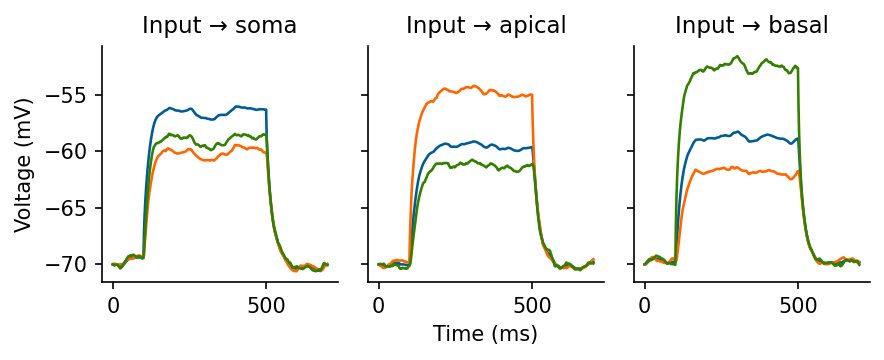

In [6]:
# @title Plot voltage traces
time = M.t/ms
voltages = [M.V_soma/mV, M.V_apical/mV, M.V_basal/mV,]
fig, axes = b.subplots(1, 3, figsize=[6, 2.5], sharex=True, sharey=True)
for idx, ax in enumerate(axes):
    for v in voltages:
        ax.plot(time, v[idx])
ax0, ax1, ax2 = axes
ax0.set_ylabel('Voltage (mV)')
ax1.set_xlabel('Time (ms)')
ax0.set_title("Input \u2192 soma")
ax1.set_title("Input \u2192 apical")
ax2.set_title("Input \u2192 basal")
fig.tight_layout()

> *Notice the electrical segmentation caused by the attenuation of currents traveling along the somatodendritic axis. Although this property may seem undesirable, it allows each compartment to operate semi-autonomously from the others, thus multiple input integration sites can coexist within a single neuron.*

## Panels c-d | Dendritic integration
> *Here, we will activate simultaneously an increasing number of synapses on the apical dendrite and measure how dendritic integration affects the somatic output. For better performance, we will perform this experiment in a vectorized manner; we will create multiple instances of the same neuron, each of which will be connected to a different number of synapses.*

In [7]:
# Create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()  # allows running separate simulations in the same notebook
Nsyn = 35  # max number of synapses
pyr_group2 = b.NeuronGroup(Nsyn, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = -50*mV',
                          refractory=3*ms, namespace=pyr_model.parameters)
pyr_model.link(pyr_group2)
# Create a source of presynaptic input (N "neurons" being activated at 50 ms)
spiketimes = [50*ms]*Nsyn
I = b.SpikeGeneratorGroup(Nsyn, range(Nsyn), spiketimes)
# Connect an increasing number of synapses to each neuron instance
synaptic_effect = "s_AMPA_cortex_apical += 1.0; s_NMDA_cortex_apical += 1.0"
S = b.Synapses(I, pyr_group2, on_pre=synaptic_effect)
S.connect('j >= i')  # j, i -> postsynaptic, presynaptic indices respectively
# Set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group2, ["V_soma", "V_apical", "V_basal"], record=True)
b.run(400*ms)
vs_control = M.V_soma/mV
va_control = M.V_apical/mV
vb_control = M.V_basal/mV

> *Also, to test the effect of the dendritic NMDA-dependent nonlinearities we will repeat the same exact protocol without activating the NMDA synaptic component (see line 16).*

In [8]:
# Create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
Nsyn = 35    # max number of synapses
pyr_group3 = b.NeuronGroup(Nsyn, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = -50*mV',
                          refractory=3*ms, namespace=pyr_model.parameters)
pyr_model.link(pyr_group3)
# Create a source of presynaptic input (N "neurons" being activated at 50 ms)
spiketimes = [50*ms]*Nsyn
I = b.SpikeGeneratorGroup(Nsyn, range(Nsyn), spiketimes)
# Connect an increasing number of synapses to each neuron instance
synaptic_effect = "s_AMPA_cortex_apical += 1.0"
S = b.Synapses(I, pyr_group3, on_pre=synaptic_effect)
S.connect('j >= i')  # j, i -> postsynaptic, presynaptic indices respectively
# Set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group3, ["V_soma", "V_apical", "V_basal"], record=True)
b.run(400*ms)
time = M.t/ms
vs_ampa = M.V_soma/mV
va_ampa = M.V_apical/mV
vb_ampa = M.V_basal/mV

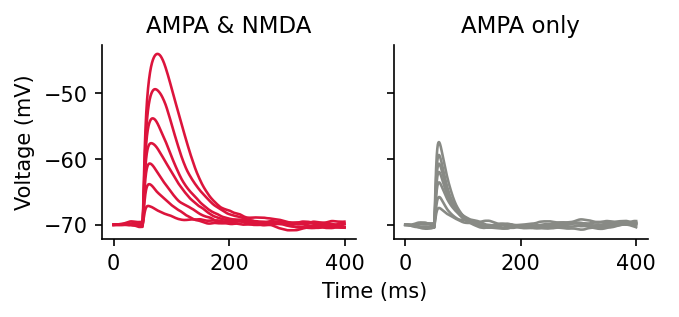

In [9]:
# @title Plot somatic responses
fig, axes = b.subplots(1, 2, figsize=[5, 2.5], sharex=True, sharey=True)
ax0, ax1 = axes
secret_ax = fig.add_subplot(111, frameon=False)
secret_ax.tick_params(labelcolor='none', which='both', bottom=False, left=False)
for i in range(Nsyn):
    if (i+1)%5 == 0:
        ax0.plot(time, vs_control[i], c='crimson')
        ax1.plot(time, vs_ampa[i], c='#888a85ff')
ax0.set_ylabel('Voltage (mV)')
ax0.set_title("AMPA & NMDA")
ax1.set_title("AMPA only")
secret_ax.set_xlabel('Time (ms)')
fig.tight_layout()

> *Notice the huge effect of the dendritic NMDA currents on both the amplitude and the kinetics of the somatic voltage responses. For visual clarity, the data shown here represent a range of 5-35 synapses with step 5. **Also, the voltage traces in the manuscript's panel appear cleaner, because we removed any noise in these experiments, to isolate the effect of the NMDA currents and increase the accuracy of EPSPs measurement**.*

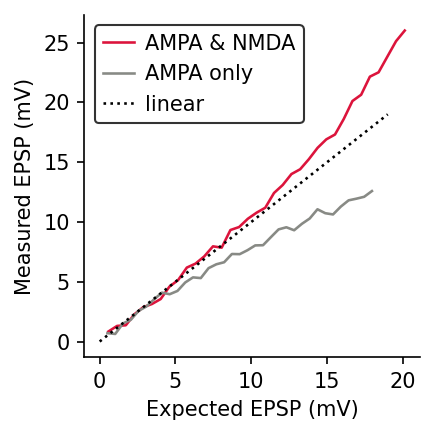

In [10]:
# @title Plot input-output function
# In this example, due to noise we cannot accurately estimate the uEPSP amplitude.
# So, we infer it by deviding a compound EPSP from 5 synapses by 5. We can do this
# because up until 5 synapses the IO relationship is very close to linear.
peaks_control = [max(v)+70 for v in vs_control]
unitary_control = peaks_control[4]/5
expected_control = b.linspace(1, 35, 35)*unitary_control
peaks_ampa = [max(v)+70 for v in vs_ampa]
unitary_ampa = peaks_ampa[4]/5
expected_ampa = b.linspace(1, 35, 35)*unitary_ampa
line = range(20)
fig, ax = b.subplots(figsize=[3, 3])
ax.plot(expected_control, peaks_control, c='crimson', label='AMPA & NMDA')
ax.plot(expected_ampa, peaks_ampa, c='#888a85ff', label='AMPA only' )
ax.plot(line, line, c='black', ls=':', label='linear')
ax.legend()
ax.set_xlabel('Expected EPSP (mV)')
ax.set_ylabel('Measured EPSP (mV)')
fig.tight_layout()

> *Notice the shift from supralinear to sublinear integration when NMDARs are blocked. This happens because synaptic currents are susceptible to the decrease in driving force as dendritic voltage approaches the AMPA reversal potential (EAMPA = 0 mV).*